## Model Selection and explanations

As we have seen, before train some models, we have done some pre-modeling : interpretability methods that we use before selecting and developing our models. This has allow us to reduce the dimensionality of the problem.

With this new dataset, we have train models chosen on two purpose :
- Random Forest for is explainability : it's an in-model : by nature interpretable
- ANN for is modeling capacity. But this is a black box model thus it's a post-model (post-Hoc) : need interpretability techniques that try to enhance model interpretability after the model has been developed

We have chosen for *IncomeInvestment* to use the random forest, which have good result and allow us easier interpretability. This choice follow the fact that this set is quite unbalance so we need easy way to interpret it.

For *AccumulationInvestment*, we could have choose also the random forest which have good result, but we have choosen the NN because we have seen that playing with hyperparameter we have obtain better results (accordingly to our business orientation).

Now we need to interpret them and we will proceed as follows :
- 1. Practice global interpretability : we want to have an overall description of different models
- 2. Self interpret the predictions made by our model. We mean have a look to the result, try to find some pattern (Unsupervised ML) and have an idea about how data are distributed in the predictions
- 3. Do some local interpretability : on the results of the second step, if we have find some "clusters" while describing the results, we will apply local methods on it

We are going to use library like Lime, Shap or Eli5

[lien] https://towardsdatascience.com/understanding-machine-learning-interpretability-168fd7562a1a https://towardsdatascience.com/three-interpretability-methods-to-consider-when-developing-your-machine-learning-model-5bf368b47fac https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/

In [ ]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# Tools'libraries
from joblib import load
import shap
#from lime import lime_tabular as LT
#import eli5

#Our function
from modelsFct import predictionEnsemble

In [17]:
# first we recup our data, models and target
%store -r X_test
%store -r Inc_test
%store -r Acc_test
%store -r data_mean
%store -r data_std

#Load the model
%store -r modIncome
%store -r modAccumulation

columns = ["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"]

In [ ]:
%store -r dataset

#data = pd.DataFrame(X_test, colums=colums)
data = dataset[["Age"]]
data[["RatioFeature"]] = dataset[["FinancialEducation"]].values/dataset[["RiskPropensity"]].values
data[["logIncome", "logWealth"]] = dataset[["logIncome", "logWealth"]]

In [3]:
predictAcc = (predictionEnsemble(modAccumulation, X) > 0.28).astype(int)
predictInc = modIncome.predict(X)

### Global Interpretability

In this first part, we would like to have a precise idea of which features have the most impact on predictions, and which kind of impact : positively or negatively. 

To do this, we use Eli5 to compute weight of features, this allow us a quick global interpretability on the model. Then we use the Shap values to validate this observation and to complete it with the sign of the impact. 


#### ELI5 for our models

Eli5 look at a model’s parameters and figure out at a global level how the model works. Let's see how behave our models



In [ ]:
#eli5.show_weights(modAccumulation, feature_names=columns[0:4]) # Return an explanation of estimator parameters (weights), for visualisation
testdf = eli5.explain_weights_df(modAccumulation,feature_names=columns[0:4]) # Explain weights and export them to pandas.DataFrame
testdf.head()


We can see that for *AccumulationInvestment*, the most impactful features are Wealth and Income. They account for approximately 75% of the prediction result. This is huge and can be interpret as a first client behaviour : the more they are at extrem values, the more the prediction is easy. We can already think that their impact are positif in the way to predict a need (true) but we will verify it with shap values.

The remaining 25% is reparted on Age and the ratio. The last one seems to have the lower impact and thus not have a particular importance. Age can still have an impact but we think that their are too many different type of people, different persona, so age can really differ.

In [ ]:
#eli5.show_weights(modIncome, feature_names=columns[0:4])
testdfinc = eli5.explain_weights_df(modIncome,feature_names=columns[0:4])
testdfinc.head()

We can see that for *IncomeInvestment*, the most important features are Wealth and Age. Wealth account for nearly 50% of the explanation, meaning the impactof it is really strong on our prediction. It seems logical and we are waiting a positif impact, meaning a big wealth will need to a true prediction, since you are able to invest. 

We were expecting a big impact of income, with the same explanation as above, but the weight is "just" to 18%. Indeed, age seems to play a bigger role, with 23%. As we have say, age is difficult to interpret so we are expecting either positive or negative impact. 

Let's have a quick visualisation of the data, to see if these impact are observable.


In [ ]:
#Plot with the target IncomeInvestment
sns.pairplot(df_true[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Acc"]], hue="Acc", data=df)
#Plot with the target IncomeInvestment
sns.pairplot(df_true[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Inc"]], hue="Inc", data=df)

We can still see that the problem is not obvious. However, really high value of wealth seems to be really impactfull and lead the prediction to true. For the rest, we need further explanation. 

So now let's use Shap values.

## Shap Values

With the help of the shap library, we will see the impact, positive or negative, of the features on the predictions. 

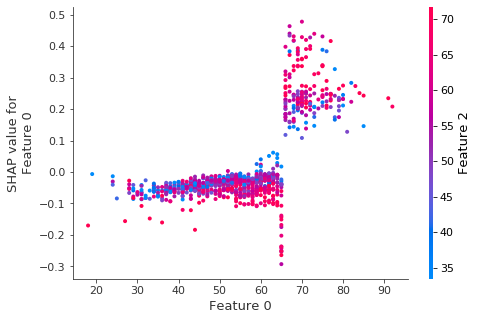

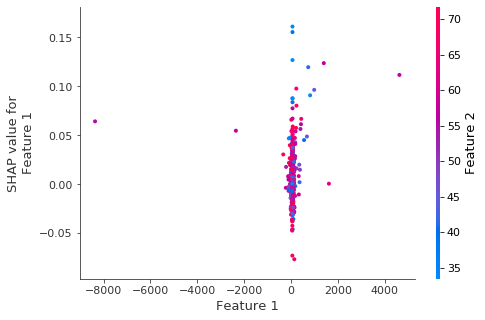

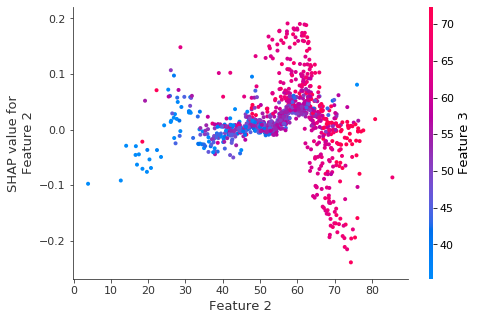

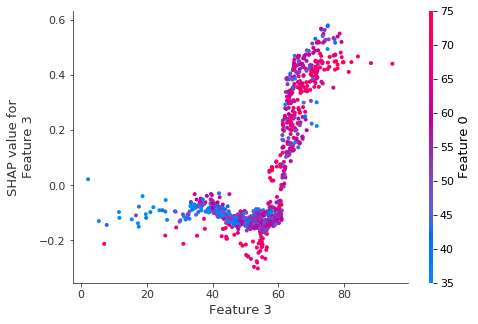

In [80]:
for feat in range(4):
    shap.dependence_plot(feat, shapValuesRF[1], X_test*data_std[0]+data_mean[0])

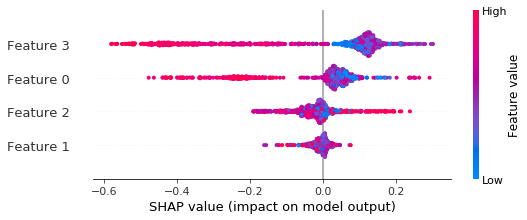

In [40]:
# Random Forest Shape values
explainerRF = shap.TreeExplainer(modIncome, feature_names=columns)
shapValuesRF = explainerRF.shap_values(X_test)
shap.summary_plot(shapValuesRF[0], X_test, class_names=columns)

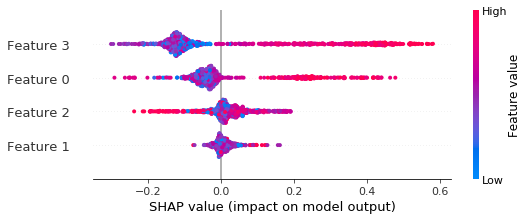

In [28]:
shap.summary_plot(shapValuesRF[1], X_test)

In [76]:
print(shapValuesRF)

[array([[ 0.02135309,  0.0008085 ,  0.00934732,  0.14023986],
       [ 0.05675985,  0.00933264, -0.02925487,  0.1256328 ],
       [-0.25407886, -0.0141522 , -0.05155308, -0.35518471],
       ...,
       [-0.2109706 ,  0.01181589, -0.10030641, -0.30945235],
       [ 0.03656892,  0.0047615 , -0.03703558,  0.14425138],
       [ 0.06234388, -0.00765153, -0.02713698,  0.14673064]]), array([[-0.02135309, -0.0008085 , -0.00934732, -0.14023986],
       [-0.05675985, -0.00933264,  0.02925487, -0.1256328 ],
       [ 0.25407886,  0.0141522 ,  0.05155308,  0.35518471],
       ...,
       [ 0.2109706 , -0.01181589,  0.10030641,  0.30945235],
       [-0.03656892, -0.0047615 ,  0.03703558, -0.14425138],
       [-0.06234388,  0.00765153,  0.02713698, -0.14673064]])]


In [72]:
print(X_test)

[[-0.18824616 -0.90840907 -0.12377666  0.02431218]
 [-1.52486573 -0.45901802 -2.40490582 -0.76514395]
 [ 1.23191213 -0.43852371  0.78067185  1.06342289]
 ...
 [ 1.39898958 10.34788303  0.62777843  0.7732794 ]
 [-0.85655594 -0.37415544  0.48428637 -0.22549872]
 [-1.19071084  0.85312932  0.51943042 -0.43610589]]


#### Artificial Neural Network Global Interpretabolity


Simple white blox model (logit)


  0%|          | 0/1000 [00:00<?, ?it/s]

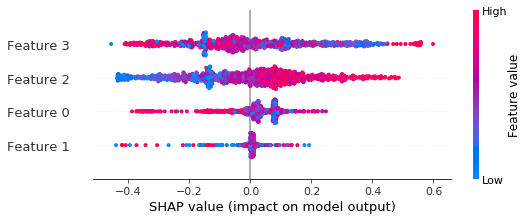

  0%|          | 0/1000 [00:00<?, ?it/s]

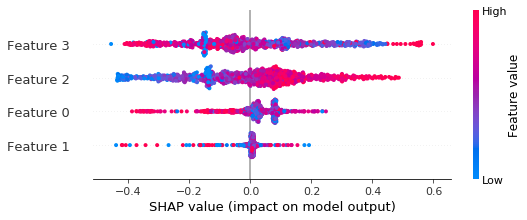

  0%|          | 0/1000 [00:00<?, ?it/s]

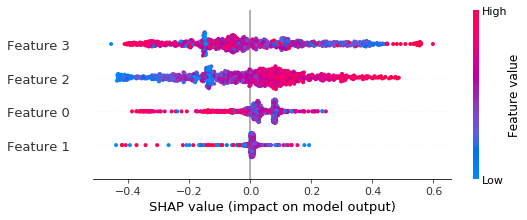

In [36]:
# Artificial Neural Network Shape values
for index in range(3):
    explainerNN = shap.KernelExplainer(modAccumulation[index], X_test[:100,:], feature_names=columns)
    shapValuesNN = explainerNN.shap_values(X_test)
    shap.summary_plot(shapValuesNN[0], X_test)

In [37]:
for index in range(3):
    explainerNN = shap.KernelExplainer(modAccumulation[index], X_test[:100,:], feature_names=columns)
    shapValuesNN = explainerNN.shap_values(X_test)
    shap.summary_plot(shapValuesNN[1], X_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: list index out of range

In [105]:
#shap.initjs()#this line is required for enabling JS with shap lib
#explainer = shap.TreeExplainer(modAccumulation)
#shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

# Conclusion on global interpretability

Feature importance and weigth for accu income ; expected or not ; positive negative ; 

Let's now see if there is some cluster inside people who have need or not. We are going to separate these people, then on each set, we are going to do first a data exploration, to have an idea and then to  train an UL model to see if some cluster appear

## let's see the data

In [106]:
data =  np.insert(X_test ,4, predRFAcc, axis=1)
data =  np.insert(data ,5, predRFInc, axis=1)
df = pd.DataFrame(data, columns=columns)
df_UL =  pd.DataFrame(X_test, columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
#df.describe()

In [107]:
mean = [data_mean[0], data_mean[3]/data_mean[4], data_mean[5], data_mean[6],0, 0]
std = [data_std[0], data_std[3]/data_std[4], data_std[5], data_std[6],1, 1]

df_true = pd.DataFrame(df*std+mean, columns=columns)
df_true.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth,Acc,Inc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.786000,1.973353,3.865530,4.132356,0.435000,0.254000
std,11.741638,27.347839,0.798926,0.907781,0.496005,0.435515
min,18.000000,-703.465770,0.430330,0.057911,0.000000,0.000000
25%,47.000000,1.141692,3.427784,3.572470,0.000000,0.000000
50%,55.000000,1.932128,3.958148,4.178830,0.000000,0.000000
75%,63.000000,2.570810,4.428945,4.757747,1.000000,1.000000
max,92.000000,384.447699,5.900783,7.183172,1.000000,1.000000


For accumulation, it is hard to see a pattern, only logincome seems to have a particular repartition.
However, as we have said, in income investment, the wealth play a big role and thus high wealth give prediction to true. We expect to have such a replication in clustering. Even age and logincome seems to have a particular shape. 

In [109]:
# let's recup exactly the peole who have need or not in both target
UL_test = df_UL.values
UL = df.values

Acc_true  = UL_test[(UL[:,4]==1)]
Acc_false = UL_test[(UL[:,4]==0)]

Inc_true  = UL_test[(UL[:,5]==1)]
Inc_false = UL_test[(UL[:,5]==0)]


We are going to train a Kmedoids model because it is less sensitive to noise and outlier in data than a Kmean.

We will do it on separating in both target into the subset of true and false prediction. Thus we have 4 dataset to model.

Text(0, 0.5, 'Inertia (within-cluster sum of squares)')

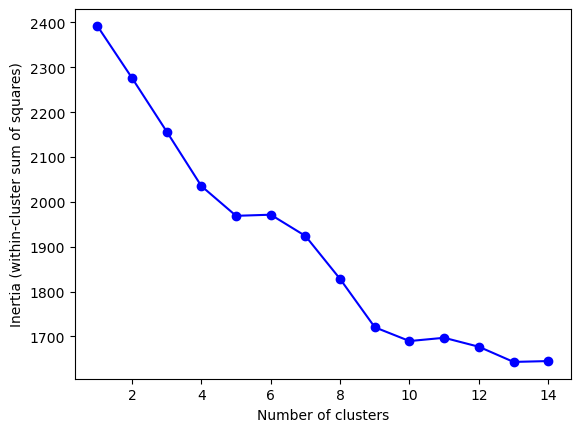

In [117]:
from sklearn_extra.cluster import KMedoids as KM

# start with accu true
Km = range(1, 15)
inertia = [KM(i).fit(Acc_true).inertia_ for i in Km]

fig = plt.figure()
plt.plot(Km, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')

In [111]:
medoids = KM(10).fit(UL_test)
labels = medoids.predict(Acc_true)
#plt.scatter(Acc_true[:, 0], Acc_true[:, 1], c=labels, s=40)

print(medoids.cluster_centers_*std[0:4] + mean[0:4])
a, count = np.unique(labels, return_counts=True)
print("classes",a,"distributed as :", count)

[[71.          2.88480128  4.65104662  5.29567803]
 [51.          0.31878009  4.13329511  4.08940645]
 [49.          2.38619807  3.94822049  3.97979394]
 [61.          1.87768428  4.59058713  4.56561126]
 [49.          1.84451166  4.38241172  4.84117527]
 [66.          1.67155543  3.9429569   4.69701509]
 [59.         -4.41255449  3.64487724  4.12280973]
 [47.          1.83829343  3.32491299  3.19880072]
 [57.         12.02348934  4.20659151  4.67297979]
 [65.          1.84176875  3.24180805  3.7583041 ]]
classes [0 1 2 3 4 5 6 7 8 9] distributed as : [60 70 91 55 36 24 24 44 19 12]


In [112]:
# if we want to see the repartition within a cluster
first = Acc_true[labels[:]==0]
tty = pd.DataFrame(first*std[0:4] + mean[0:4], columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
tty.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth
count,60.000000,60.000000,60.000000,60.000000
mean,68.933333,3.131831,4.745010,5.392748
std,8.550680,1.404973,0.494298,0.622705
min,52.000000,0.670778,3.382266,4.102450
25%,63.000000,2.132974,4.612903,4.864535
50%,69.000000,2.708741,4.805110,5.407265
75%,75.250000,3.743147,5.103396,5.844091
max,92.000000,6.449044,5.591129,7.183172


Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

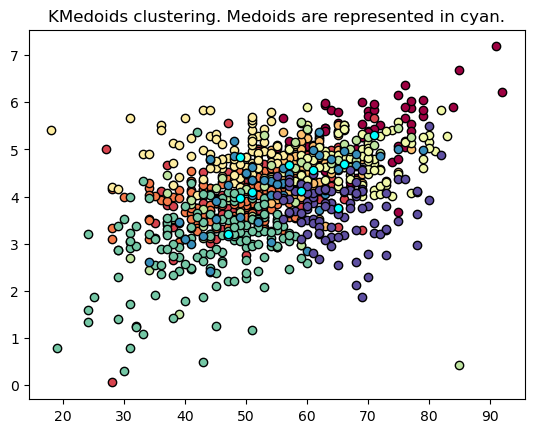

In [116]:
labels = medoids.labels_
cluster = medoids.cluster_centers_*std[0:4] + mean[0:4],
i, j = 0,3
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = UL_test[class_member_mask]
    plt.plot(
        xy[:, i]*std[i] + mean[i],
        xy[:, j]*std[j] + mean[j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    medoids.cluster_centers_[:, i]*std[i] + mean[i],
    medoids.cluster_centers_[:, j]*std[j] + mean[j],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

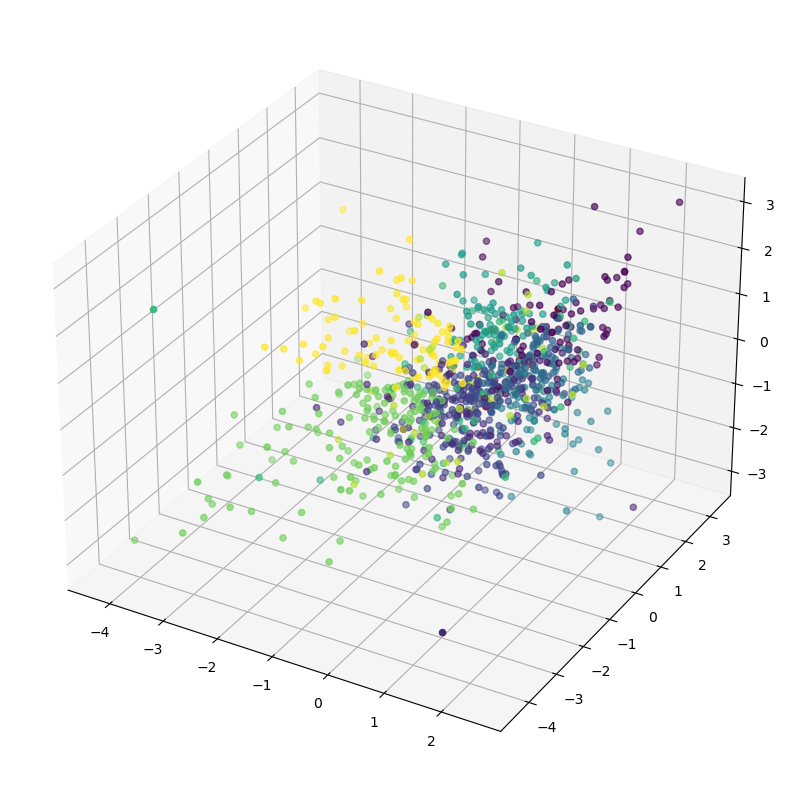

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["logIncome"], df["logWealth"],df["Age"], c=labels ) 
ax.scatter(medoids.cluster_centers_[:,2], medoids.cluster_centers_[:,3],medoids.cluster_centers_[:,0], c="r" ) 

plt.show()


# Local interpretability 

Do shap eli5 or other on : 
- cluster center
- exagerated data made by hand
- outlier or simple sample 

conclude